# Sujet 2 : Où sont localisés les logements AirBnb ?

**Objectif** : caractériser la répartition spatiale des logements AirBnb

Quels sont les facteurs socio-économiques qui expliquent la localisation des logements Airbnb ? Comment comparer les concentrations des logements Airbnb entre les trois villes disponibles (Paris, Lyon et Bordeaux) ? 

Nous vous recommandons pour les aspects cartographiques de consulter le notebook : **Comment faire une carte à partir de données ponctuelles** 

## Code pour charger les données

In [1]:
!pip install -q -q -q geopandas # pour traiter les data frame spatiales
!pip install -q -q -q btbpy # pour réaliser un lissage spatiale
!pip install -q -q -q mapclassify # pour calculer les discrétisations
!pip install -q -q -q contextily # pour afficher un fond OpenstreetMap
!pip install -q -q -q rtree

In [2]:
import os
import s3fs
import pandas as pd
import geopandas as gpd
import btbpy as btb
import matplotlib.pyplot as plt
import contextily as cx
from sklearn.cluster import DBSCAN

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-funathon/diffusion/data/paris/2021-04-10/listings.csv.gz', 'listings.csv.gz') # import des données depuis minio
listings = pd.read_csv('listings.csv.gz',compression='gzip')

In [4]:
listings.head(2)

id                        listing_url       scrape_id last_scraped  \
0  2577  https://www.airbnb.com/rooms/2577  20210410122610   2021-04-14   
1  3109  https://www.airbnb.com/rooms/3109  20210410122610   2021-04-13   

                               name  \
0  Loft for 4 by Canal Saint Martin   
1                      zen and calm   

                                         description  \
0  100 m2 loft (1100 sq feet) with high ceiling, ...   
1  <b>The space</b><br />I bedroom appartment in ...   

                               neighborhood_overview  \
0                                                NaN   
1  Good restaurants<br />very close the Montparna...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/09da057c-0120...     2827   
1  https://a0.muscache.com/pictures/baeae9e2-cd53...     3631   

                                 host_url  ... review_scores_communication  \
0  https://www.airbnb.com/users/show/2827  ...                        10.0   
1  https://www.airbnb.com/users/show/3631  ...                        10.0   

  review_scores_location review_scores_value license instant_bookable  \
0                   10.0                10.0     NaN                f   
1                   10.0                10.0     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              1                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.04  
1                                           0              0.17  

[2 rows x 74 columns]

## Pour débuter

### La répartition des logements

On développe une démarche pédestre, en allant pas à pas dans la difficulté. La premiére idée est de directement cartographier la localisation des logements Airbnb.

In [5]:
slistings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude)).set_crs("EPSG:4326").to_crs("EPSG:2154") 

(6857121.84, 6867229.71)

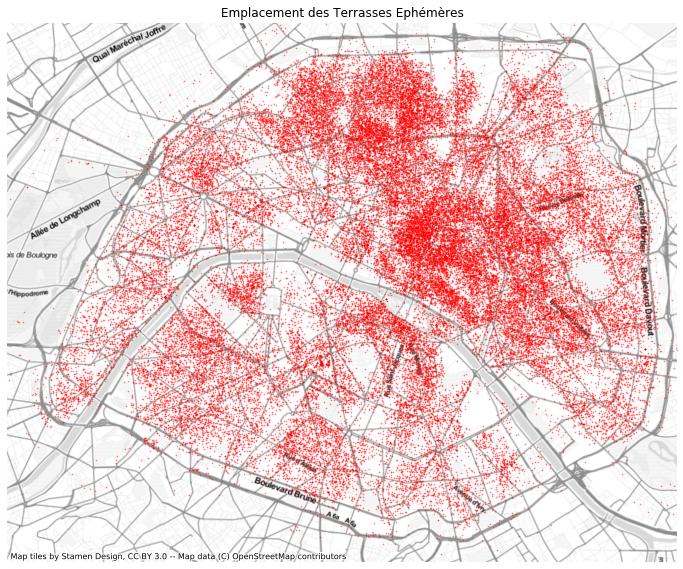

In [6]:
ax = slistings.plot(markersize=0.5, figsize=(12,14), color='red', alpha=0.4) #figsize définit la taille de la carte
ax.set_axis_off()
cx.add_basemap(ax, crs=slistings.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Emplacement des Terrasses Ephémères")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))

Pour aller plus loin, on calcule une carte de densité des logements en carroyant les données.

In [26]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-funathon/diffusion/data/filosofi2015/filosofi.gpkg', 'filosofi.gpkg')

filosofi = gpd.read_file('filosofi.gpkg')
filosofi.drop('index_right', axis=1, inplace=True) # pour éviter un bug avec le sjoin 

In [28]:
slistings['densite'] = 1

In [29]:
temp = gpd.sjoin(slistings, filosofi, how="inner", op='intersects')

In [30]:
clistings = temp.groupby(['IdINSPIRE'], as_index=False)['densite'].sum()
clistings.densite = clistings.densite / 0.2**2

In [31]:
clistings = filosofi.merge(clistings, on = 'IdINSPIRE')

(6857121.84, 6867229.71)

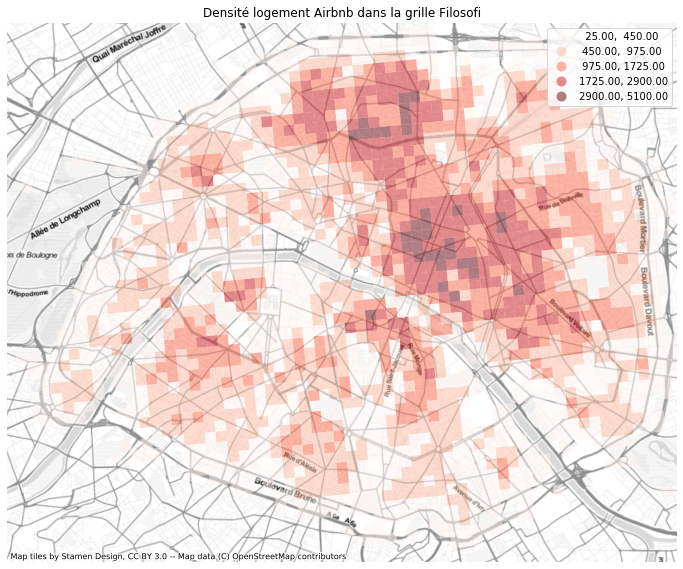

In [33]:
ax = clistings.plot('densite', figsize=(12,14), legend=True, scheme='FisherJenksSampled', cmap='Reds', alpha=0.5)
ax.set_axis_off()
cx.add_basemap(ax, crs=slistings.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Densité logement Airbnb dans la grille Filosofi")
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))

In [ ]:
La carte de densité permet de localiser les zones de forte concentration de logements Airbnb. La notion de cluster permet d'approfondir la localisation des zones de forte densité. 

### Recherche des clusters de logements à l'aide de la dbscan



In [72]:
slistings['x'] = slistings.geometry.x
slistings['y'] = slistings.geometry.y
db = DBSCAN(eps=200, min_samples=400).fit(slistings[['x', 'y']])

In [76]:
slistings['cluster'] = db.labels_

Text(0.5, 1, 'Représentation des clusters')

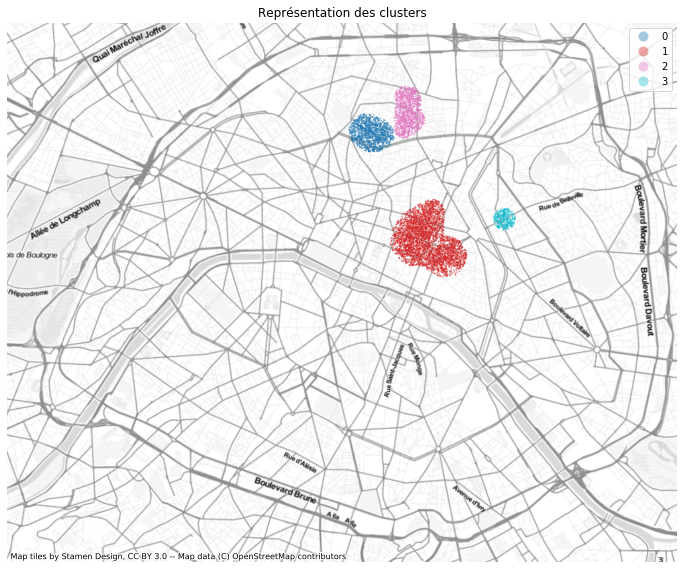

In [78]:
ax = slistings[slistings.cluster>-1].plot('cluster',markersize=0.5, figsize=(12,14), alpha=0.4, categorical=True, legend=True )
ax.set_xlim((644601.05,657161.71))
ax.set_ylim((6857121.84,6867229.71))
ax.set_axis_off()
cx.add_basemap(ax, crs=slistings.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_title("Représentation des clusters")